In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import re
import json
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
input_dir = 'inputs/Cody_1p2T'
output_dir = 'outputs/Cody_1p2T'

In [4]:
def collect_params(input_filename):
    if not input_filename.endswith('.json'):
        filename_part1, _ = os.path.splitext(input_filename)
        input_filename = f'{filename_part1}.json'
    input_path = os.path.join(input_dir, input_filename)
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    spins = data['spinsys']['spins']
    spin_Hs = []
    spin_bulk = None
    for spin in spins:
        if spins[spin]['type'] == 'e':
            spin_e = spins[spin]
        elif spins[spin]['type'] == 'H1':
            spin_Hs.append(spins[spin])
        elif spins[spin]['type'] == 'BulkH':
            spin_bulk = spins[spin]
    t1e = spin_e['t1']
    t2e = spin_e['t2']
    if spin_bulk is not None:
        t1_bulk = spin_bulk['t1']
        t2_bulk = spin_bulk['t2']
    else:
        t1_bulk, t2_bulk = None, None
        
    t1ns = []
    t2ns = []
    for spin in spin_Hs:
        t1ns.append(spin['t1'])
        t2ns.append(spin['t2'])
        
    p = data['pulseseq']['sections']['mix']['size']
    loop = data['pulseseq']['sections']['train']['size']
    d = data['pulseseq']['sections']['d']['size']
    return t1e, t2e, t1ns, t2ns, t1_bulk, t2_bulk, p, loop, d

In [5]:
os.listdir(input_dir)

['eHHB_NOVEL_fp_param18.json',
 'eHHB_NOVEL_fp_param35.json',
 'eHHB_NOVEL_fp_SE_param17.json',
 'eHHB_NOVEL_fp_param32.json',
 'eHHB_NOVEL_fp_param6.json',
 'eHHB_NOVEL_fp_param44.json',
 'eH_NOVEL_fp_param1.json',
 'eHHB_NOVEL_fp_param11.json',
 'eHB_NOVEL_fp_param2.json',
 'eH_NOVEL_fp_param22.json',
 'eHB_NOVEL_fp_param13.json',
 'eH_NOVEL_fp_param12.json',
 'eHB_NOVEL_fp_param7.json',
 'eHB_NOVEL_fp_param27.json',
 'eHB_NOVEL_fp_param16.json',
 'eHB_NOVEL_fp_param42.json',
 'eH_NOVEL_fp_param21.json',
 'eHHB_NOVEL_fp_param2.json',
 'eHB_NOVEL_fp_param28.json',
 'eHHB_NOVEL_fp_param47.json',
 'eHB_NOVEL_fp_param10.json',
 'eHHB_NOVEL_fp_param8.json',
 'eHHB_NOVEL_fp_param10.json',
 'eHHB_NOVEL_fp_param15.json',
 'eHB_NOVEL_fp_param6.json',
 'eHB_NOVEL_fp_param41.json',
 'eH_NOVEL_fp_param16.json',
 'eHB_NOVEL_fp_param29.json',
 'eH_NOVEL_fp_param20.json',
 'eHHB_NOVEL_fp_param24.json',
 'eHB_NOVEL_fp_param39.json',
 'eHHB_NOVEL_fp_param12.json',
 'eHHB_NOVEL_fp_param42.json',
 'eHB

In [6]:
res1 = collect_params('eH_NOVEL_fp_param16.json')

In [7]:
res1

(0.004, 5e-07, [1], [0.001], None, None, 100000, 100, 1000000)

In [8]:
def params_to_label(collection):
    part1 = f't1e{collection[0]*1e3:.3f}ms;t2e{collection[1]*1e6:.1f}us'
    part2 = ''
    for t1n, t2n in zip(collection[2], collection[3]):
        temp = f't1n{t1n:.1f}s;t2n{t2n*1e3:.1f}ms'
        part2 += temp
    part3 = ''
    if collection[4] is not None and collection[5] is not None:
        part3 = f't1n_bulk{collection[4]:.1f}s; t2n_bulk{collection[5]*1e3:.1f}ms'
    part4 = f'p{collection[6]};loop{collection[7]};d{collection[8]//1000}us'
    return '|'.join([part1, part2, part3, part4])

In [9]:
params_to_label(res1)

't1e4.000ms;t2e0.5us|t1n1.0s;t2n1.0ms||p100000;loop100;d1000us'

<IPython.core.display.Javascript object>


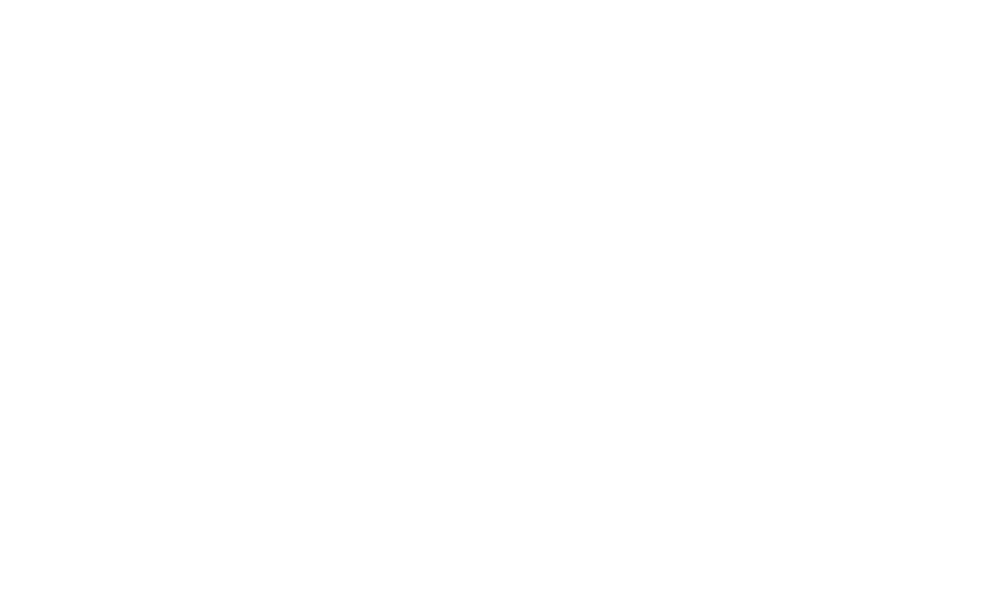

param42: t1e0.010ms;t2e4.0us|t1n1.0s;t2n1.0ms|t1n_bulk1.0s; t2n_bulk10.0ms|p10000;loop100;d200us
param42: t1e0.010ms;t2e4.0us|t1n1.0s;t2n1.0mst1n1.0s;t2n1.0ms|t1n_bulk1.0s; t2n_bulk10.0ms|p10000;loop100;d200us
param43: t1e0.010ms;t2e4.0us|t1n1.0s;t2n1.0mst1n1.0s;t2n1.0ms|t1n_bulk1.0s; t2n_bulk10.0ms|p5000;loop1000;d200us
param44: t1e0.010ms;t2e4.0us|t1n1.0s;t2n1.0mst1n1.0s;t2n1.0ms|t1n_bulk1.0s; t2n_bulk10.0ms|p5000;loop500;d200us
param45: t1e0.010ms;t2e4.0us|t1n1.0s;t2n1.0mst1n1.0s;t2n1.0ms|t1n_bulk1.0s; t2n_bulk10.0ms|p5000;loop500;d200us
param46: t1e0.010ms;t2e4.0us|t1n1.0s;t2n1.0mst1n1.0s;t2n1.0ms|t1n_bulk1.0s; t2n_bulk10.0ms|p7000;loop500;d200us


In [10]:
scaler = preprocessing.MinMaxScaler()

filenames = [
#     'eH_NOVEL_fp_param1.result',
#     'eH_NOVEL_fp_param2.result',
#     'eH_NOVEL_fp_param3.result',
#     'eH_NOVEL_fp_param4.result',
#     'eH_NOVEL_fp_param5.result',
#     'eH_NOVEL_fp_param6.result',
#     'eH_NOVEL_fp_param7.result',
#     'eH_NOVEL_fp_param8.result',
#     'eH_NOVEL_fp_param9.result',
#     'eH_NOVEL_fp_param10.result',
#     'eH_NOVEL_fp_param11.result',
#     'eH_NOVEL_fp_param12.result',
#     'eH_NOVEL_fp_param13.result',
#     'eH_NOVEL_fp_param14.result',
#     'eH_NOVEL_fp_param15.result',
#     'eH_NOVEL_fp_param16.result',
#     'eH_NOVEL_fp_param17.result',
#     'eH_NOVEL_fp_param18.result',
#     'eH_NOVEL_fp_param19.result',
#     'eH_NOVEL_fp_param20.result',
#     'eH_NOVEL_fp_param21.result',
#     'eH_NOVEL_fp_param22.result',
#     'eH_NOVEL_fp_param23.result',
#     'eH_NOVEL_fp_param24.result',
#     'eH_NOVEL_fp_param25.result',
#     'eHB_NOVEL_fp_param2.result',
#     'eHB_NOVEL_fp_param3.result',
#     'eHB_NOVEL_fp_param4.result',
#     'eHB_NOVEL_fp_param5.result',
#     'eHB_NOVEL_fp_param6.result',
#     'eHB_NOVEL_fp_param7.result',
#     'eHB_NOVEL_fp_param8.result',
#     'eHB_NOVEL_fp_param9.result',
#     'eHB_NOVEL_fp_param10.result',
#     'eHB_NOVEL_fp_param11.result',
#     'eHB_NOVEL_fp_param12.result',
#     'eHB_NOVEL_fp_param13.result',
#     'eHB_NOVEL_fp_param14.result',
#     'eHB_NOVEL_fp_param15.result',
#     'eHB_NOVEL_fp_param16.result',
#     'eHB_NOVEL_fp_param17.result',
#     'eHB_NOVEL_fp_param18.result',
#     'eHB_NOVEL_fp_param19.result',
#     'eHB_NOVEL_fp_param20.result',
#     'eHB_NOVEL_fp_param21.result',
#     'eHB_NOVEL_fp_param22.result',
#     'eHB_NOVEL_fp_param23.result',
#     'eHB_NOVEL_fp_param24.result',
#     'eHB_NOVEL_fp_param25.result',
#     'eHB_NOVEL_fp_param26.result',
#     'eHB_NOVEL_fp_param27.result',
#     'eHHB_NOVEL_fp_param1.result',
#     'eHHB_NOVEL_fp_param2.result',
#     'eHB_NOVEL_fp_param28.result',
#     'eHB_NOVEL_fp_param29.result',
#     'eHHB_NOVEL_fp_param4.result',
#     'eHHB_NOVEL_fp_param5.result',
#     'eHHB_NOVEL_fp_param6.result',
#     'eHHB_NOVEL_fp_param7.result',
#     'eHHB_NOVEL_fp_param8.result',
#     'eHHB_NOVEL_fp_param9.result',
#     'eHHB_NOVEL_fp_param10.result',
#     'eHHB_NOVEL_fp_param11.result',
#     'eHHB_NOVEL_fp_param12.result',

#     'eHHB_NOVEL_fp_param13.result',
#     'eHHB_NOVEL_fp_param14.result',
    
#     'eHHB_NOVEL_fp_param15.result',
#     'eHHB_NOVEL_fp_param16.result',
    
#     'eHHB_NOVEL_fp_param17.result',
    
#     'eHHB_NOVEL_fp_param18.result',

#     'eHHB_NOVEL_fp_param19.result',
#     'eHHB_NOVEL_fp_param20.result',
#     'eHHB_NOVEL_fp_param21.result',
#     'eHHB_NOVEL_fp_param22.result',
# #     'eHHB_NOVEL_fp_param23.result',
    
#     'eHHB_NOVEL_fp_param24.result',
#     'eHHB_NOVEL_fp_param25.result',
    
#     'eHHB_NOVEL_fp_param26.result',
#     'eHHB_NOVEL_fp_param27.result',
#     'eHHB_NOVEL_fp_param28.result',
#     'eHHB_NOVEL_fp_param29.result',
#     'eHHB_NOVEL_fp_param30.result',
#     'eHHB_NOVEL_fp_param31.result',
#     'eHB_NOVEL_fp_param31.result',
#     'eHB_NOVEL_fp_param32.result',
#     'eHHB_NOVEL_fp_param32.result',
#     'eHHB_NOVEL_fp_param33.result',
#     'eHHB_NOVEL_fp_param34.result',
    
#     'eHHB_NOVEL_fp_param35.result',
#     'eHHB_NOVEL_fp_param36.result',

#     'eHB_NOVEL_fp_param37.result',
#     'eHB_NOVEL_fp_param38.result',
#     'eHB_NOVEL_fp_param39.result',
#     'eHB_NOVEL_fp_param40.result',
#     'eHB_NOVEL_fp_param41.result',
    
    'eHB_NOVEL_fp_param42.result',
    'eHHB_NOVEL_fp_param42.result',
    'eHHB_NOVEL_fp_param43.result',
    'eHHB_NOVEL_fp_param44.result',
    'eHHB_NOVEL_fp_param45.result',
    'eHHB_NOVEL_fp_param46.result',
]

n = len(filenames)
colors = plt.cm.rainbow(np.linspace(0,1,n))
marker_inventory = ['^', 'o', 's', 'D', '*', 'x', '+', '^']
markers = []
for i in range(n):
    markers.append(marker_inventory[i%len(marker_inventory)])

fig = plt.figure(figsize=(10,6))
for filename, c, m in zip(filenames, colors, markers):
    filepath = os.path.join(output_dir, filename)
    df = pd.read_csv(filepath, skiprows=1, header=None)
#     y_scaled = scaler.fit_transform(df.iloc[:, -1].values.reshape(-1,1)) - 0.25
#     df.iloc[:, -1] = y_scaled
    label_content = params_to_label(collect_params(filename))
    label_index = filename.split('.')[0].split('_')[-1]
    label = f'{label_index}'
    print(f'{label_index}: {label_content}')
    plt.plot(df[0], df[1], f'.-', color=c, markerfacecolor='none', label=label)
plt.hlines(0, 1.192, 1.1995)
# plt.vlines(1.19566, -0.5, 0.75)
plt.vlines(1.19566, -20, 60)
plt.legend(loc='lower left')
plt.show()

<IPython.core.display.Javascript object>


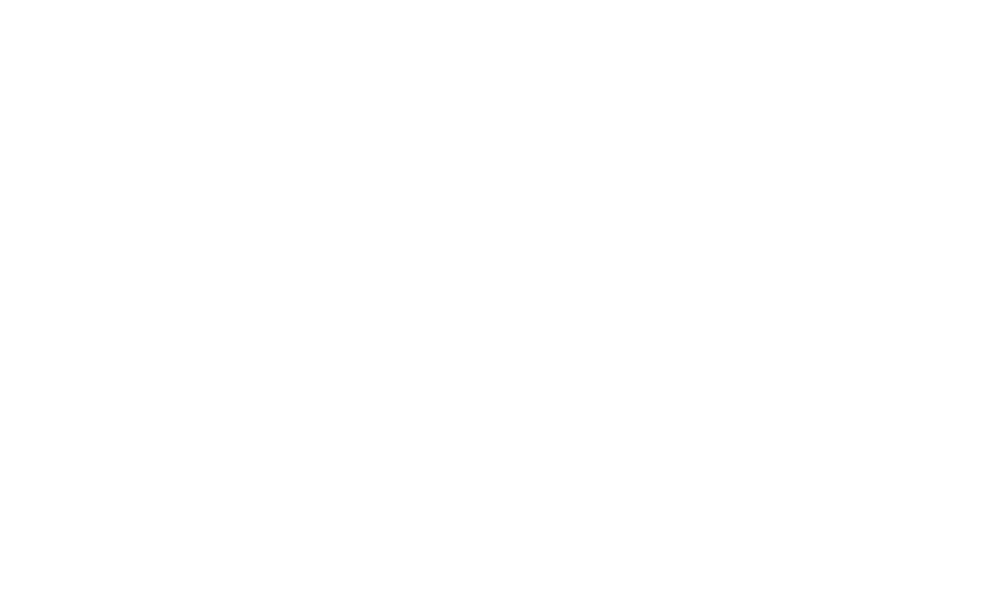

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
scaler = preprocessing.MinMaxScaler()

filename = 'eHHB_NOVEL_fp_param47.result'
filename0 = 'eHHB_NOVEL_fp_param47_SE.result'

fig = plt.figure(figsize=(10,6), dpi=100)
filepath = os.path.join(output_dir, filename)
df = pd.read_csv(filepath, skiprows=1, header=None)
#     y_scaled = scaler.fit_transform(df.iloc[:, -1].values.reshape(-1,1))
#     df.iloc[:, -1] = y_scaled
label = 'NOVEL'
df0 = pd.read_csv(os.path.join(output_dir, filename0), skiprows=1, header=None)
plt.plot(df[0], df[1], f'ro-', markerfacecolor='none', label=label)
label0 = 'SE'
plt.plot(df0[0], df0[1], f'ks-', markerfacecolor='none', label=label0)
# plt.plot(df[0], df[1]-df0[1], 'b--')
plt.hlines(0, 1.192, 1.1995)
plt.vlines(1.19566, -90, 120)
plt.xlim(1.192, 1.1995)
plt.ylim(-90, 120)
plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Enhancement (a.u.)')
plt.savefig('CA-NOVEL_1p2T_Figure3b.ps')
plt.show()

## More scanning

In [12]:
def collect_results_gB1(result_dir, param_dir):
    xs = []
    ys = []
    for filename in sorted(list(os.listdir(result_dir))):
        val = 0.0
        filepath = os.path.join(result_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                val = float(line.strip())
                break
        ys.append(val)

        name_part, ext = os.path.splitext(filename)
        param_filename = f'{name_part}.json'
        filepath = os.path.join(param_dir, param_filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            x = data['pulseseq']['components']['emr2']['e']['frequency']/1e6
            xs.append(float(x))
    return xs, ys

def collect_results_length(result_dir, param_dir, param_name):
    xs = []
    ys = []
    for filename in sorted(list(os.listdir(result_dir))):
        val = 0.0
        filepath = os.path.join(result_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                val = float(line.strip())
                break
        ys.append(val)

        name_part, ext = os.path.splitext(filename)
        param_filename = f'{name_part}.json'
        filepath = os.path.join(param_dir, param_filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            x = data['pulseseq']['sections'][param_name]['size']
            xs.append(float(x))
    return xs, ys

def collect_results_fp(result_dir, param_dir):
    xs = []
    ys = []
    for filename in sorted(list(os.listdir(result_dir))):
        val = 0.0
        filepath = os.path.join(result_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                val = float(line.strip())
                break
        ys.append(val)

        name_part, ext = os.path.splitext(filename)
        param_filename = f'{name_part}.json'
        filepath = os.path.join(param_dir, param_filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            x = data['settings']['Magnet']['b0']
            xs.append(float(x))
    return xs, ys

In [13]:
def get_label(collection_name, eofe_res_dir):
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    param_filename = list(os.listdir(param_dir))[0]
    param_path = os.path.join(param_dir, param_filename)
    with open(param_path,'r',encoding='utf-8') as f:
        data = json.load(f)
        if data['settings']['Magnet']['b0'] < 1.0:
            field = 'xband'
        else:
            field = 'qband'
        loop = data['pulseseq']['sections']['loop']['size']
        if loop < 1000:
            loop = f'{loop}'
        else:
            loop = f'{loop//1000}k'
        mix = data['pulseseq']['sections']['mix']['size']
        if mix < 1000:
            mix = f'{mix}ns'
        else:
            mix = f'{mix//1000}us'
        d = data['pulseseq']['sections']['d']['size']
        if d < 1000:
            d = f'{d}ns'
        elif d < 1e6:
            d = f'{d//1000}us'
        else:
            d = f'{d//1000000}ms'
        t1e = data['spinsys']['spins']['0']['t1'] * 1000.0
        t2e = data['spinsys']['spins']['0']['t2'] * 1.0e6
        t1n = data['spinsys']['spins']['1']['t1'] 
        t2n = data['spinsys']['spins']['1']['t2'] * 1.0e3
        spin_e = data['spinsys']['spins']['0']
        spin_H1 = data['spinsys']['spins']['1']
        spin_H2 = data['spinsys']['spins']['2']
        spin_H3 = data['spinsys']['spins']['3']
        d_e_h1 = np.sqrt((spin_e['x'] - spin_H1['x'])**2 + (spin_e['y'] - spin_H1['y'])**2 + (spin_e['z'] - spin_H1['z'])**2)
        d_e_h3 = np.sqrt((spin_e['x'] - spin_H3['x'])**2 + (spin_e['y'] - spin_H3['y'])**2 + (spin_e['z'] - spin_H3['z'])**2)
        d_h1_h2 = np.sqrt((spin_H1['x'] - spin_H2['x'])**2 + (spin_H1['y'] - spin_H2['y'])**2 + (spin_H1['z'] - spin_H2['z'])**2)
        result = f'{field} t1e{t1e:.2f}ms t2e{t2e:.1f}us t1n{t1n:.1f}s t2n{t2n:.1f}ms eH1:{d_e_h1:.1f}A eH3:{d_e_h3:.1f}A H1-2:{d_h1_h2:.1f}A d{d} mix{mix} loop{loop}'
    return result

<IPython.core.display.Javascript object>


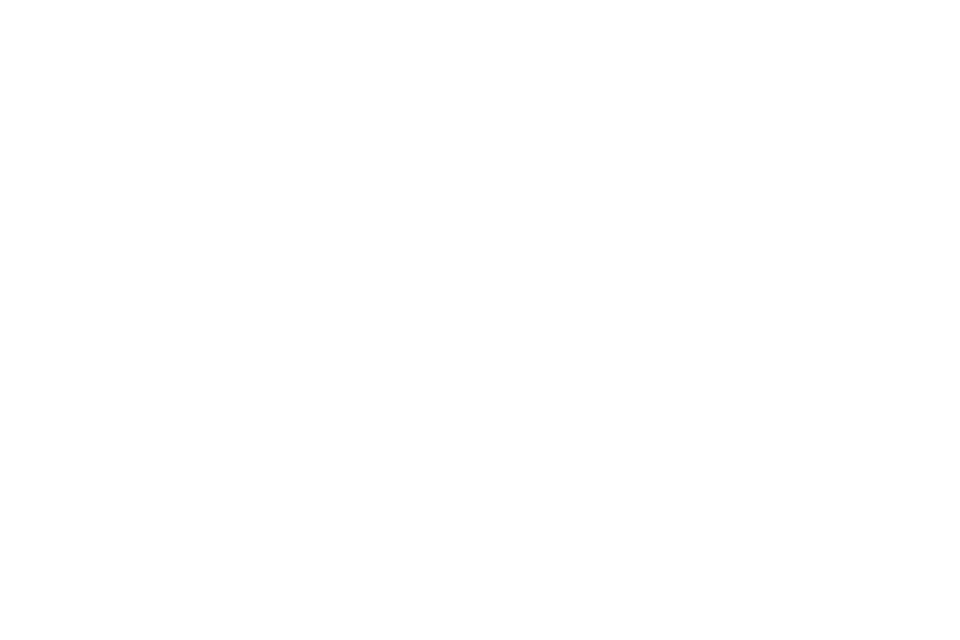

3.678172093721091e-05
1.9793716633724268e-05
3.1920786987460015e-05
3.568155517944718e-05
3.632765832661047e-05
3.8666972476636374e-05
3.8779810073555194e-05
3.62708339246497e-05


In [14]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

fig = plt.figure(figsize=(12, 8), dpi=80)

collection_name = 'qband_p12_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'bo-', markerfacecolor='none', 
         label='qband loop100 mix6us')
print(ys[np.argmax(ys)])

# collection_name = 'qband_p12_mix1k_fp'
# xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
# plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'rs-', markerfacecolor='none', 
#          label='qband loop100 mix1us')
# print(ys[np.argmax(ys)])

collection_name = 'qband_p12_mix20k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'gx-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p13_mix20k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'mD-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p13_mix20k_loop500_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'c+-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p13_mix20k_loop3k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'y^-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p13_mix20k_d400k_loop3k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'r^-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p14_mix20k_d400k_loop3k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'bo-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p14_mix20k_d200k_loop3k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'ms-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])



plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


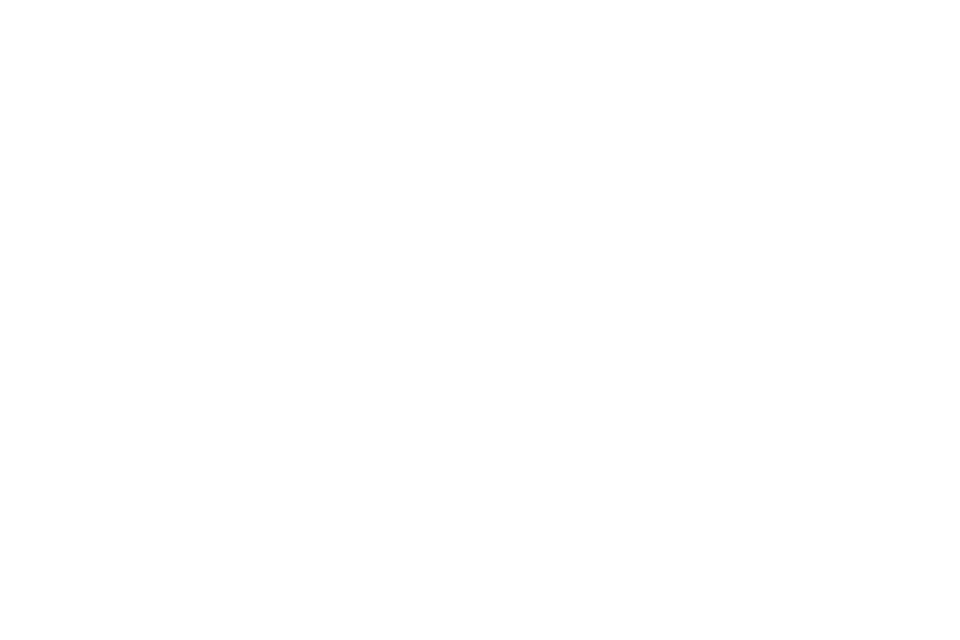

4.34817251069186e-05
4.8753768705194813e-05
4.7651611954664265e-05
5.2036884243418715e-05


In [15]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

fig = plt.figure(figsize=(12, 8), dpi=80)

# collection_name = 'qband_p14_mix20k_d400k_loop3k_fp'
# xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
# plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'b+-', markerfacecolor='none', 
#          label='qband loop3k mix20us d0.4ms t2e8us t2n1ms')
# print(ys[np.argmax(ys)])

# collection_name = 'qband_p14_mix20k_d200k_loop3k_fp'
# xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
# plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'mo-', markerfacecolor='none', 
#          label='qband loop3k mix20us d0.2ms t2e8us t2n1ms')
# print(ys[np.argmax(ys)])

collection_name = 'qband_p14_mix10k_d100k_loop3k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'c^-', markerfacecolor='none', 
         label='qband loop3k mix10us d0.1ms t2e8us t2n1ms')
print(ys[np.argmax(ys)])

# collection_name = 'qband_p14_mix10k_d100k_loop10k_fp'
# xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
# plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'r^-', markerfacecolor='none', 
#          label='qband loop10k mix10us d0.1ms t2e8us t2n1ms')
# print(ys[np.argmax(ys)])

collection_name = 'qband_p15_mix10k_d100k_loop500_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'r^-', markerfacecolor='none', 
         label='qband loop500 mix10us d0.1ms t2e8us t2n1ms e-H3 1.8A')
print(ys[np.argmax(ys)])

# collection_name = 'qband_p16_mix10k_d100k_loop500_fp'
# xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
# plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'gD-', markerfacecolor='none', 
#          label='qband loop500 mix10us d0.1ms t2e1us t2n1ms e-H3 1.8A')
# print(ys[np.argmax(ys)])

collection_name = 'qband_p17_mix10k_d100k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'bs-', markerfacecolor='none', 
         label='qband loop1k mix10us d0.1ms t2e1us t2n1ms e-H3 1.8A e-H1 5A')
print(ys[np.argmax(ys)])

collection_name = 'qband_p18_mix10k_d100k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'ms-', markerfacecolor='none', 
         label='qband loop1k mix10us d0.1ms t2e1us t2n1ms e-H3 1.8A e-H1 3.5A')
print(ys[np.argmax(ys)])



plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


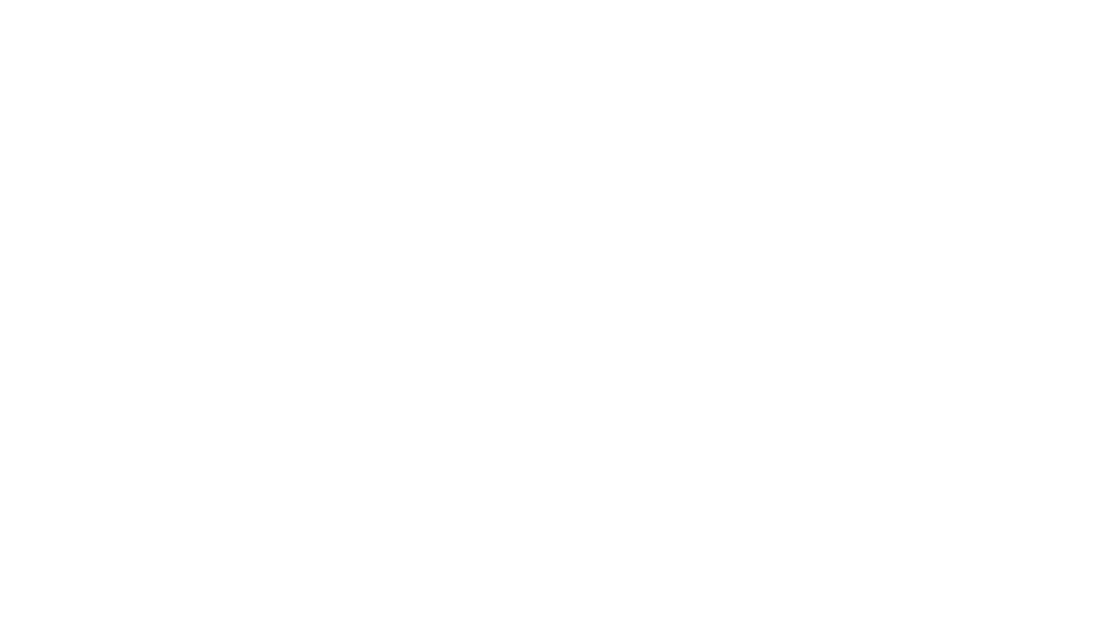

4.34817251069186e-05
5.2036884243418715e-05
4.979789113683136e-05
4.838989494419307e-05
4.9588586517675404e-05
3.434150379086822e-05


In [16]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p14_mix10k_d100k_loop3k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'c^-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p18_mix10k_d100k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'ms-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p19_mix10k_d100k_loop3k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'rD-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

# collection_name = 'qband_p20_mix10k_d100k_loop3k_fp'
# xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
# plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'bD-', markerfacecolor='none', 
#          label=get_label(collection_name, eofe_results_root))
# print(ys[np.argmax(ys)])

# collection_name = 'qband_p21_mix10k_d100k_loop3k_fp'
# xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
# plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'yx-', markerfacecolor='none', 
#          label=get_label(collection_name, eofe_results_root))
# print(ys[np.argmax(ys)])

collection_name = 'qband_p22_mix10k_d100k_loop30k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'go-', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p18_mix5k_d50k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'o-', color='grey', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p23_mix5k_d50k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'D-', color='darkred', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])


plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


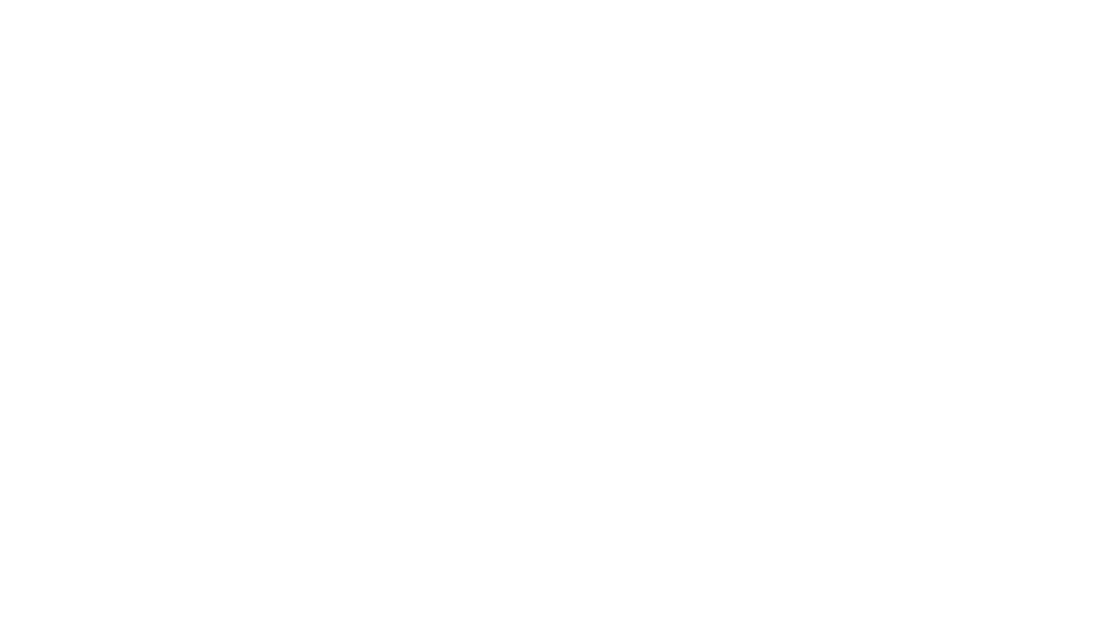

4.9588586517675404e-05
3.434150379086822e-05
7.077953705780664e-05
5.005438688924552e-05
5.485364389611664e-05


In [17]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

fig = plt.figure(figsize=(14, 8), dpi=80)


collection_name = 'qband_p18_mix5k_d50k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'o-', color='grey', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p23_mix5k_d50k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'D-', color='darkred', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p24_mix5k_d500k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 'x-', color='red', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p25_mix5k_d500k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], '^-', color='blue', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

collection_name = 'qband_p26_mix5k_d500k_loop1k_fp'
xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], '+-', color='darkblue', markerfacecolor='none', 
         label=get_label(collection_name, eofe_results_root))
print(ys[np.argmax(ys)])

plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


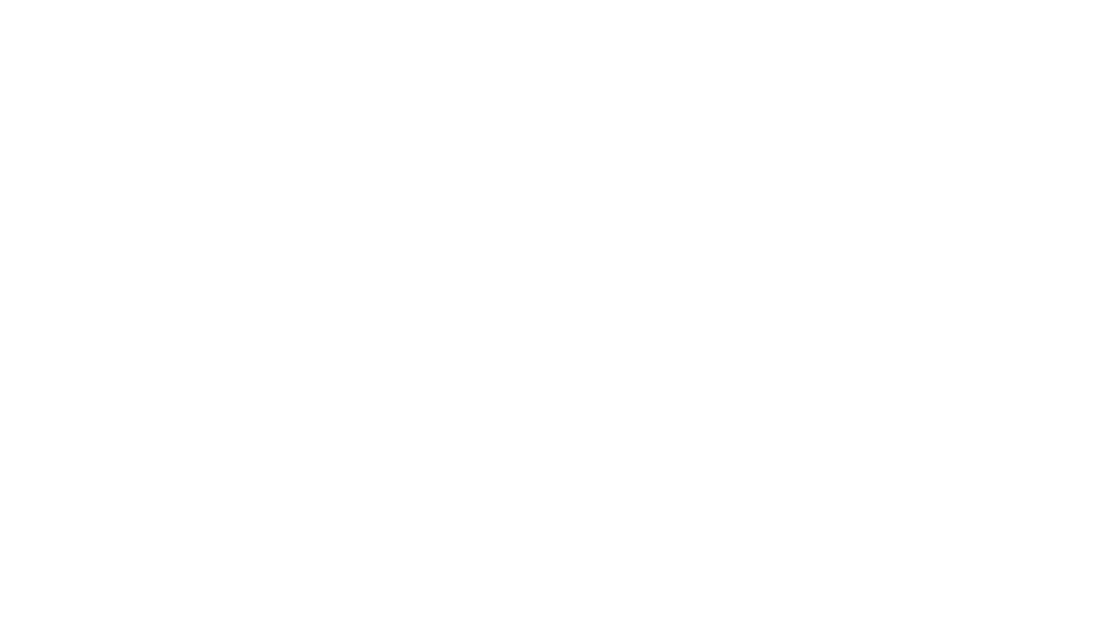

5.485364389611664e-05
6.869661195006626e-05
6.345219029080273e-05
1.2081280401245712e-05
1.2147784904441715e-05
1.6699191752745193e-05
5.9078461397542085e-06


In [18]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
    plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p26_mix5k_d500k_loop1k_fp'
plot_collection(collection_name, 'o', 'red')

collection_name = 'qband_p27_mix5k_d500k_loop500_fp'
plot_collection(collection_name, '^', 'blue')

collection_name = 'qband_p28_mix5k_d500k_loop500_fp'
plot_collection(collection_name, '+', 'green')

collection_name = 'qband_p29_mix5k_d500k_loop500_fp'
plot_collection(collection_name, 's', 'cyan')

collection_name = 'qband_p29_mix5k_d500k_loop5k_fp'
plot_collection(collection_name, 'D', 'darkblue')

collection_name = 'qband_p30_mix5k_d500k_loop500_fp'
plot_collection(collection_name, '*', 'darkred')

collection_name = 'qband_p31_mix5k_d500k_loop500_fp'
plot_collection(collection_name, '<', 'darkgreen')


plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


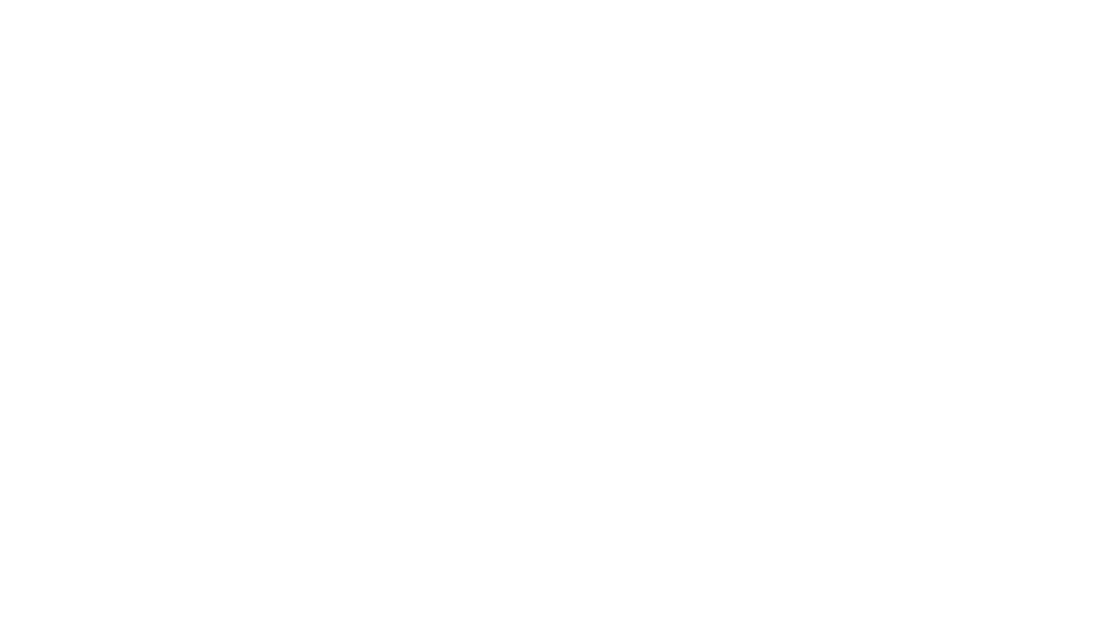

5.9078461397542085e-06
1.5110002465464886e-05
1.0312612547361465e-05
3.126948179484434e-05
2.959263961969928e-05
2.959263961969928e-05


In [19]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
    plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p31_mix5k_d500k_loop500_fp'
plot_collection(collection_name, '^', 'darkgreen')

collection_name = 'qband_p32_mix5k_d500k_loop500_fp'
plot_collection(collection_name, 's', 'green')

collection_name = 'qband_p32_mix5k_d100k_loop500_fp'
plot_collection(collection_name, 'x', 'lightgreen')

collection_name = 'qband_p33_mix5k_d100k_loop500_fp'
plot_collection(collection_name, 'o', 'darkblue')

collection_name = 'qband_p33_mix5k_d100k_loop100_fp'
plot_collection(collection_name, 'D', 'blue')

collection_name = 'qband_p33_mix5k_d100k_loop100p0_fp'
plot_collection(collection_name, '+', 'lightblue')

plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


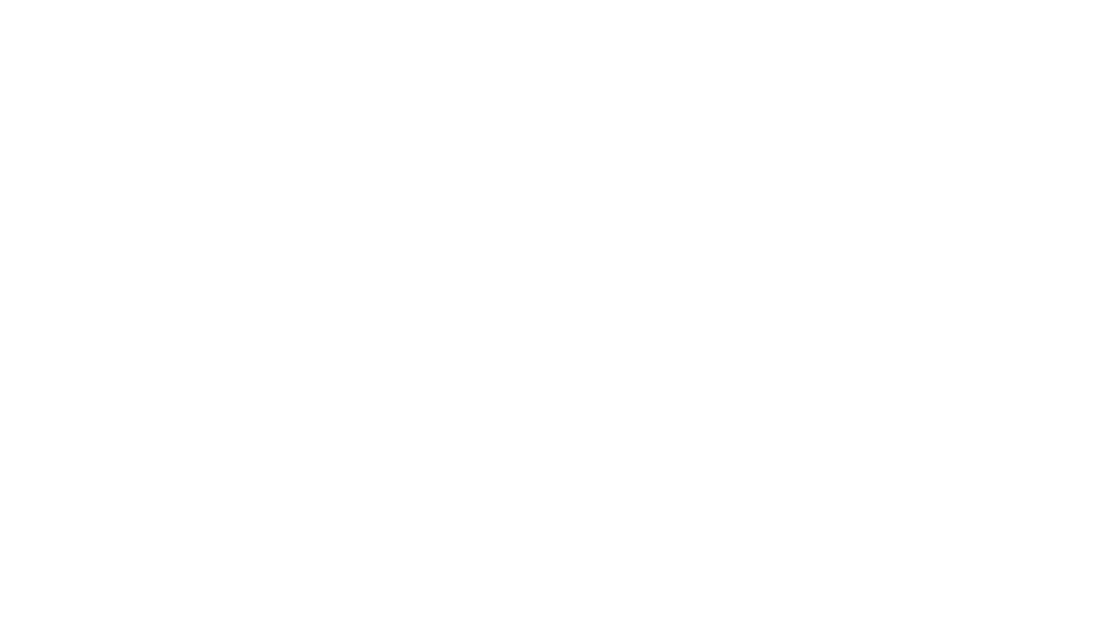

1.5159121520684207e-05
2.2353912760060952e-05
2.415525582856162e-05
2.7481448250211285e-05
2.750197079089806e-05
1.791885999349966e-05


In [20]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
    plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_1e3H1B_p34_mix5k_d100k_loop100_fp'
plot_collection(collection_name, '^', 'darkgreen')

collection_name = 'qband_1e3H1B_p34_mix3k_d100k_loop100_fp'
plot_collection(collection_name, 'o', 'green')

collection_name = 'qband_1e3H1B_p34_mix3k_d100k_loop400_fp'
plot_collection(collection_name, '+', 'lightgreen')

collection_name = 'qband_p35_mix6k_d100k_loop500_fp'
plot_collection(collection_name, 's', 'red')

collection_name = 'qband_p36_mix6k_d100k_loop500_fp'
plot_collection(collection_name, 'x', 'darkred')

collection_name = 'qband_p36_mix10k_d100k_loop500_fp'
plot_collection(collection_name, 'D', 'salmon')


plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


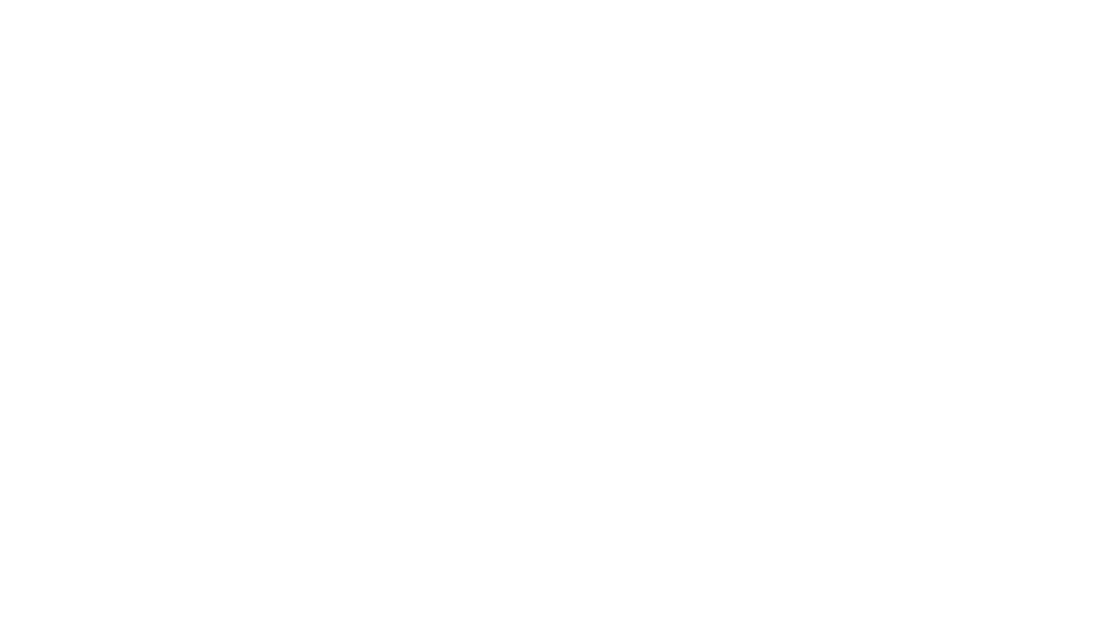

1.7644839977455016e-05
3.145060334245628e-05
0.00014048793796741076
9.086907996839931e-06


In [21]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
    plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p37_mix10k_d100k_loop500_fp'
plot_collection(collection_name, 'D', 'salmon')

collection_name = 'qband_p37_mix5k_d100k_loop500_fp'
plot_collection(collection_name, 's', 'red')

collection_name = 'qband_p37_mix1k_d100k_loop500_fp'
plot_collection(collection_name, 'o', 'darkred')

collection_name = 'qband_1e3H1B_p38_mix10k_d100k_loop500_fp'
plot_collection(collection_name, 'x', 'blue')


plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


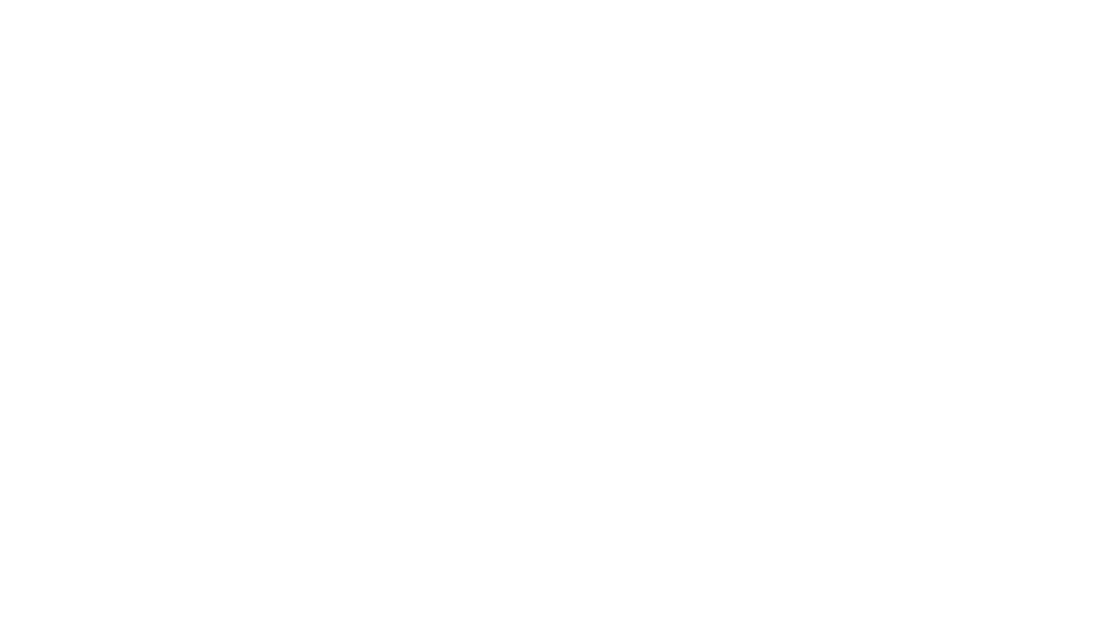

1.8392650093169796e-05
1.483420824552255e-05


In [22]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
    plt.plot(np.array(xs), np.array(ys)/ys[np.argmax(ys)], 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p39_mix10k_d100k_loop500_fp'
plot_collection(collection_name, 'o', 'darkred')

collection_name = 'qband_p39_mix10k_d100k_loop10_fp'
plot_collection(collection_name, '^', 'red')


plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


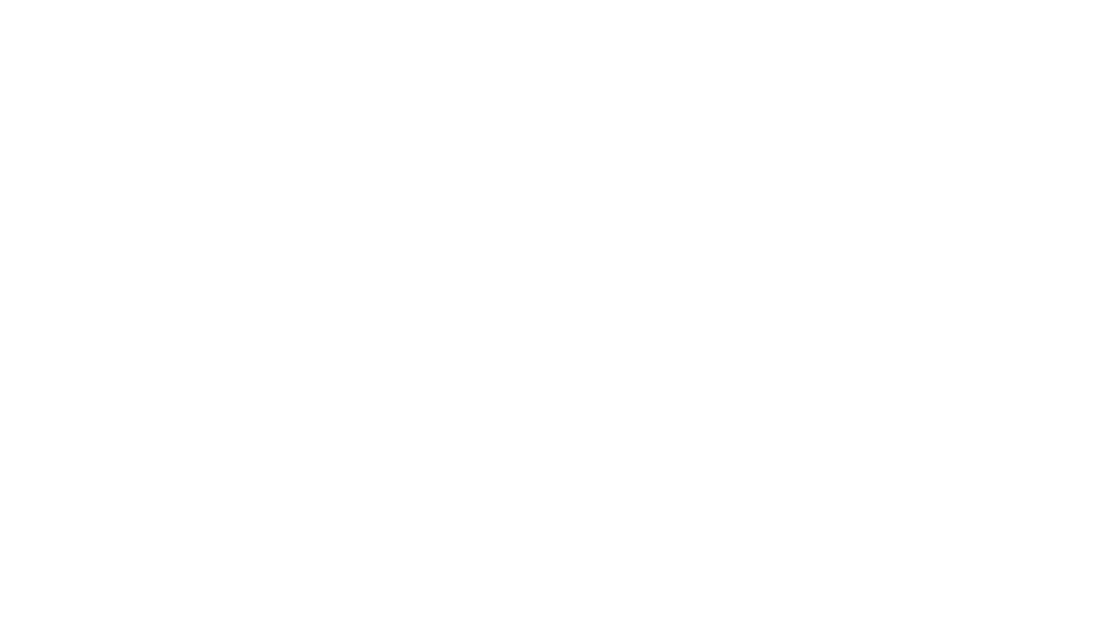

8.906269570108082e-06
6.993846890984609e-06
1.0312612547361465e-05
9.488084969242742e-06
6.043564527242749e-06
5.010810036844649e-06


In [23]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
    plt.plot(np.array(xs), np.array(ys), 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p32_mix5k_d100k_loop50_fp'
plot_collection(collection_name, 'o', 'darkred')

collection_name = 'qband_p32_mix5k_d100k_loop10_fp'
plot_collection(collection_name, '^', 'red')

collection_name = 'qband_p32_mix5k_d100k_loop500_fp'
plot_collection(collection_name, 'x', 'salmon')

collection_name = 'qband_p40_mix5k_d100k_loop100_fp'
plot_collection(collection_name, 's', 'lightblue')
collection_name = 'qband_p40_mix10k_d100k_loop100_fp'
plot_collection(collection_name, 'D', 'blue')
collection_name = 'qband_p40_mix20k_d200k_loop100_fp'
plot_collection(collection_name, '+', 'darkblue')

plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


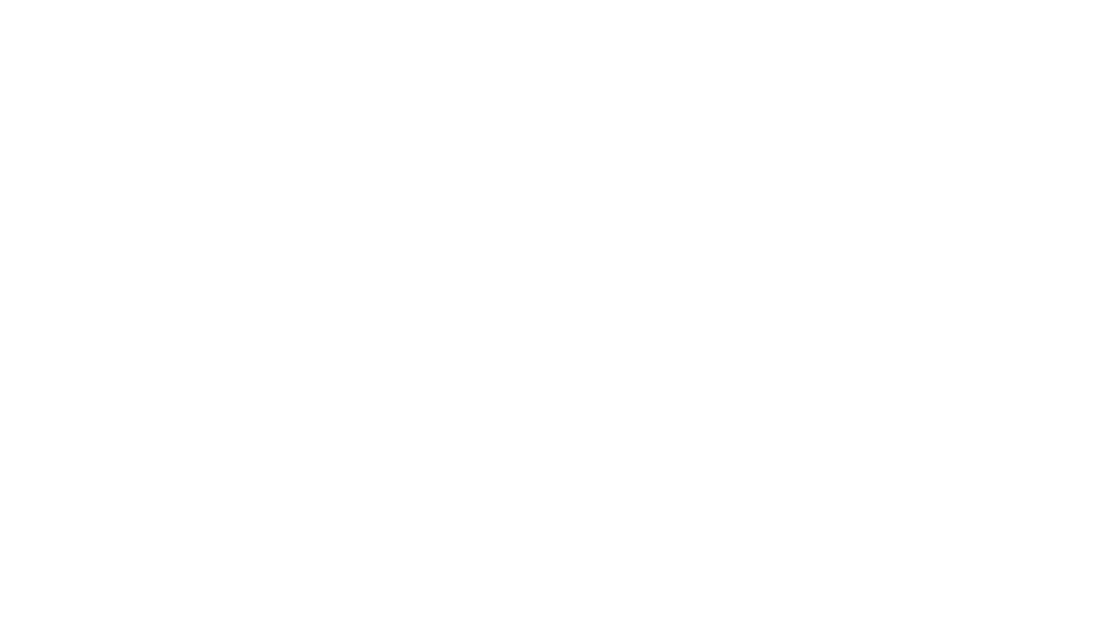

6.043564527242749e-06
6.045771999515694e-06
4.27855344853041e-06
1.0046879399025566e-05
3.7228456736360164e-06
2.936856393686089e-06
1.0378451769467935e-05


In [24]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
    ys_max = ys[np.argmax(ys)]
    plt.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p40_mix10k_d100k_loop100_fp'
plot_collection(collection_name, 'D', 'lightblue')
collection_name = 'qband_p41_mix10k_d100k_loop100_fp'
plot_collection(collection_name, 'x', 'blue')
collection_name = 'qband_p41_1_mix10k_d100k_loop100_fp'
plot_collection(collection_name, 'o', 'salmon')
collection_name = 'qband_p41_2_mix10k_d100k_loop100_fp'
plot_collection(collection_name, 's', 'red')
collection_name = 'qband_p41_3_mix10k_d100k_loop100_fp'
plot_collection(collection_name, 'D', 'darkred')
collection_name = 'qband_p41_4_mix10k_d100k_loop100_fp'
plot_collection(collection_name, '^', 'm')
collection_name = 'qband_p41_2_mix10k_d100k_loop1000_fp'
plot_collection(collection_name, '+', 'c')


plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


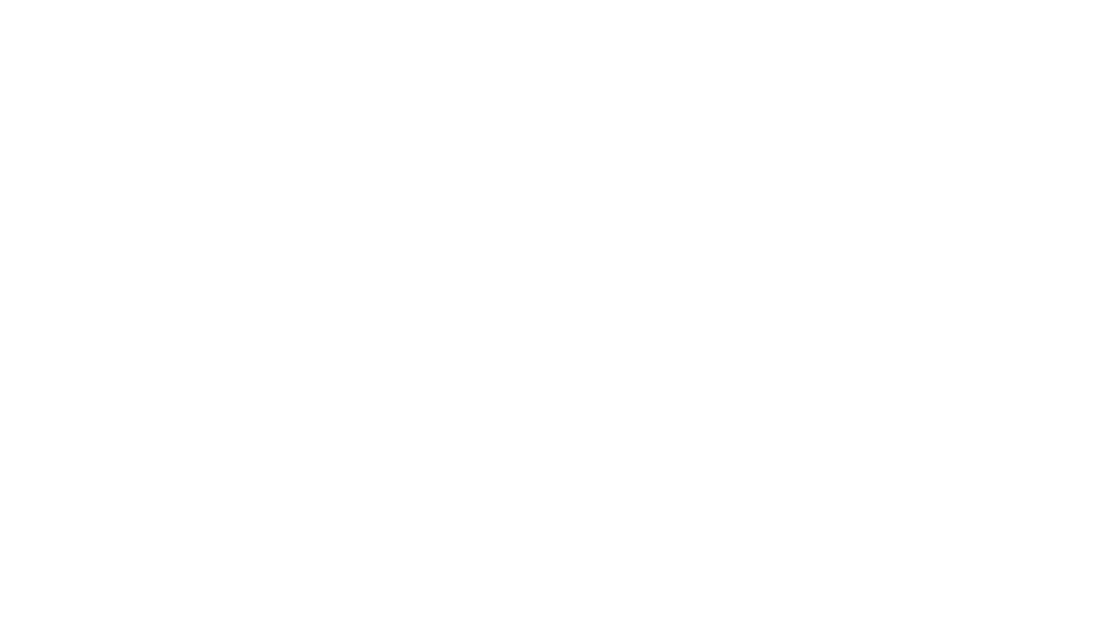

9.096107619948943e-05
0.00012225894248573446
0.0002134291584117406
0.00020629477350523053
0.00018378707710813117


In [25]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    plt.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p42_mix20k_d200k_loop100_fp'
plot_collection(collection_name, 'o', 'darkblue')
collection_name = 'qband_p43_mix20k_d200k_loop100_fp'
plot_collection(collection_name, 'x', 'blue')
collection_name = 'qband_p44_mix20k_d200k_loop100_fp'
plot_collection(collection_name, 's', 'lightblue')
collection_name = 'qband_p45_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, 'D', 'cyan')
collection_name = 'qband_p45_mix20k_d200k_loop100_fp_se'
xs0, ys0 = plot_collection(collection_name, '+', 'red')
diff = np.array(ys) - np.array(ys0)
plt.plot(xs, diff, 'k--')


plt.vlines(1.1957, -0.5e-5, 1e-5, linestyle='dashed')
plt.hlines(0, 1.192, 1.2, linestyle='dotted')

plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


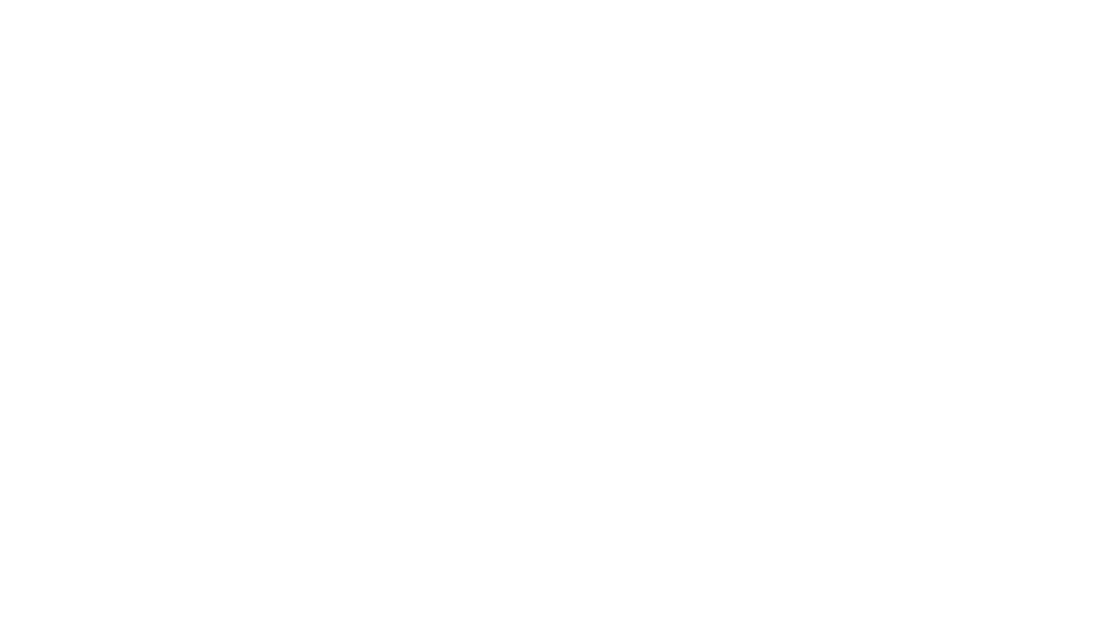

5.416388156982731e-05
5.416388156982731e-05
2.8994892203142208e-05
2.8994892203142208e-05
2.9313810126282446e-05
2.9313810126282446e-05
5.1317378167206646e-05
5.1317378167206646e-05
5.271080650806245e-05
5.271080650806245e-05
7.608143098926604e-05
7.608143098926604e-05


In [26]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, ax, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    ax.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(14, 8), dpi=80)
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1)

collection_name = 'qband_p46_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, 'o', 'darkblue')
xs, ys = plot_collection(collection_name, ax2, 'o', 'darkblue')

collection_name = 'qband_p47_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, 'x', 'blue')
xs, ys = plot_collection(collection_name, ax2, 'x', 'blue')

collection_name = 'qband_p48_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'lightblue')
xs, ys = plot_collection(collection_name, ax2, '^', 'lightblue')

collection_name = 'qband_p49_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'lightgreen')
xs, ys = plot_collection(collection_name, ax2, '^', 'lightgreen')

collection_name = 'qband_p50_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'green')
xs, ys = plot_collection(collection_name, ax2, '^', 'green')

collection_name = 'qband_p51_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, 'D', 'darkgreen')
xs, ys = plot_collection(collection_name, ax2, 'D', 'darkgreen')

ax1.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
ax1.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

ax1.legend(loc='lower right')
ax2.set_ylim(-0.5e-6, 4e-6)
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


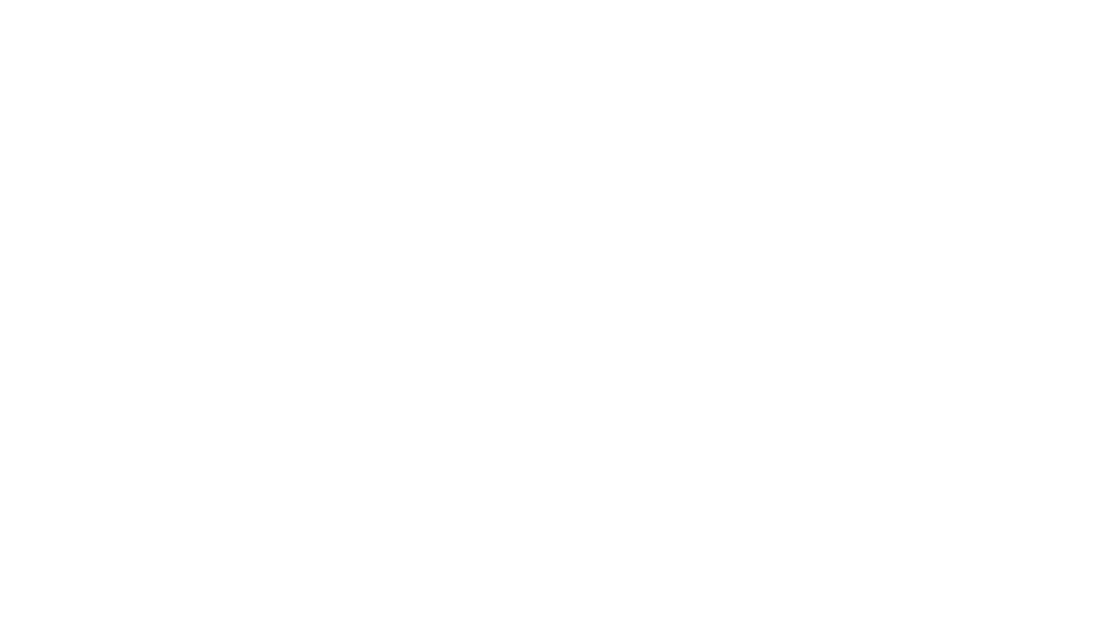

7.916779568635374e-05
8.149648209418961e-05
0.00010434361680647296
0.00010045780863378209
0.00014930086298172056


In [27]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    plt.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p52_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, 's', 'darkred')

collection_name = 'qband_p53_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, '+', 'red')

collection_name = 'qband_p54_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, 'x', 'salmon')

collection_name = 'qband_p55_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, 'o', 'coral')

collection_name = 'qband_p56_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, 'D', 'orange')

plt.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
plt.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


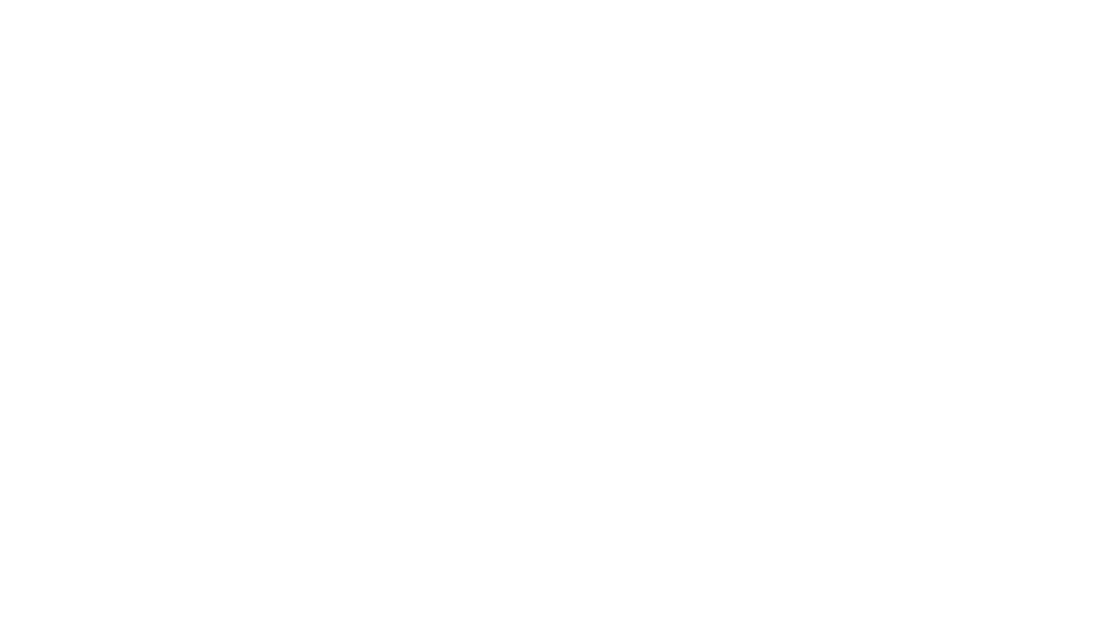

0.00010045780863378209
5.6879014749822866e-05


In [28]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    plt.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p55_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, 'o', 'red')

collection_name = 'qband_p55_flip1_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, '^', 'blue')


plt.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
plt.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


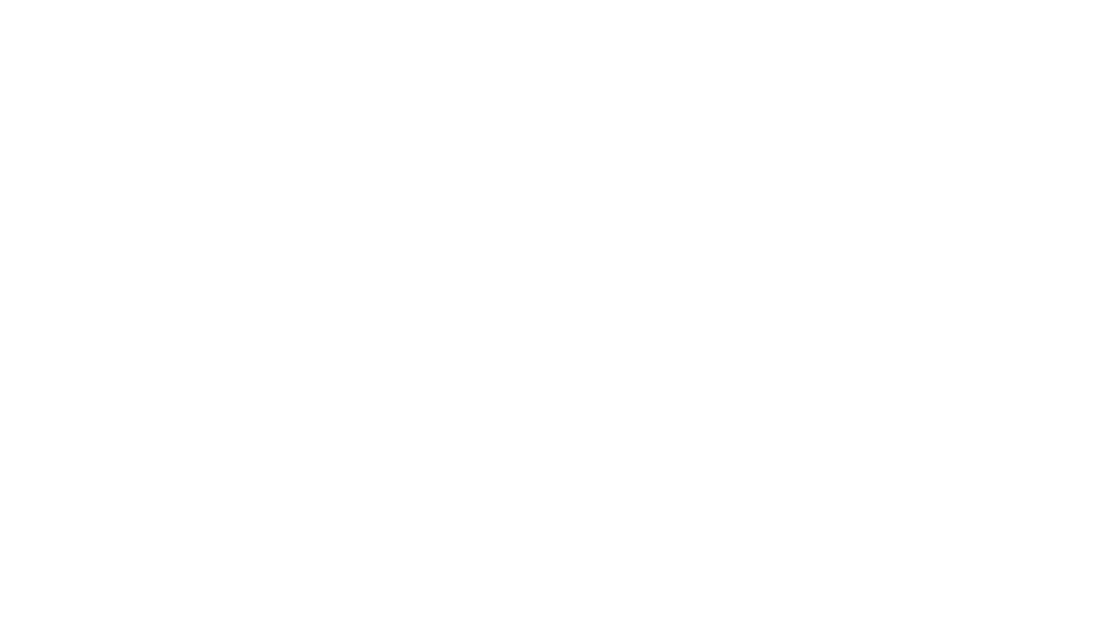

5.712073940353929e-05
5.712073940353929e-05
5.639735321153733e-05
5.639735321153733e-05
6.283650577763235e-05
6.283650577763235e-05
8.013709862436673e-05
8.013709862436673e-05
7.829356438884906e-05
7.829356438884906e-05
7.380843107095397e-05
7.380843107095397e-05
2.9593088203508258e-05
2.9593088203508258e-05


In [41]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, ax, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    ax.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(14, 8), dpi=80)
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1) 

collection_name = 'qband_p57_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, 'x', 'red')
xs, ys = plot_collection(collection_name, ax2, 'x', 'red')

collection_name = 'qband_p58_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, 'o', 'darkred')
xs, ys = plot_collection(collection_name, ax2, 'o', 'darkred')

collection_name = 'qband_p59_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, 's', 'salmon')
xs, ys = plot_collection(collection_name, ax2, 's', 'salmon')

collection_name = 'qband_p60_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '+', 'orange')
xs, ys = plot_collection(collection_name, ax2, '+', 'orange')

collection_name = 'qband_p61_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, 'D', 'tan')
xs, ys = plot_collection(collection_name, ax2, 'D', 'tan')

collection_name = 'qband_p62_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'b')
xs, ys = plot_collection(collection_name, ax2, '^', 'b')

collection_name = 'qband_p63_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'lightblue')
xs, ys = plot_collection(collection_name, ax2, '^', 'lightblue')

ax1.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
ax1.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

ax2.set_ylim(0.2e-6, 3e-6)

ax1.legend(loc='lower right')
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


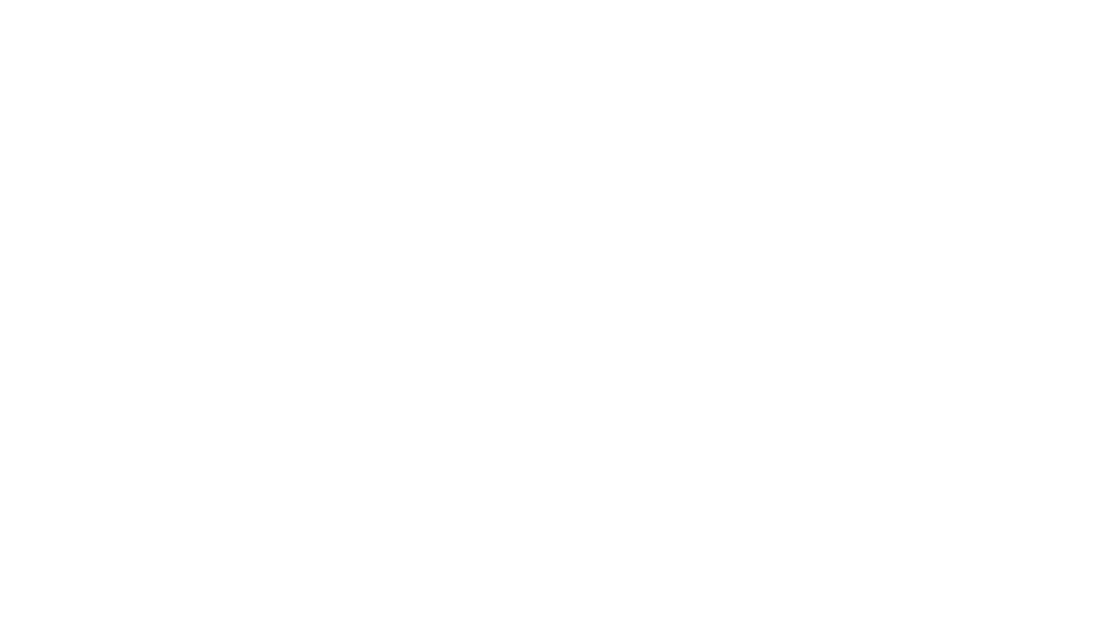

7.380843107095397e-05
3.429253483978414e-05
5.6879014749822866e-05
7.806464657006622e-05


In [42]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    plt.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(14, 8), dpi=80)

collection_name = 'qband_p62_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, 'o', 'red')

collection_name = 'qband_p62_flip1_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, '^', 'salmon')

collection_name = 'qband_p55_flip1_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, '^', 'blue')

collection_name = 'qband_p56_flip1_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, '^', 'cyan')


plt.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
plt.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

plt.legend()
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

<IPython.core.display.Javascript object>


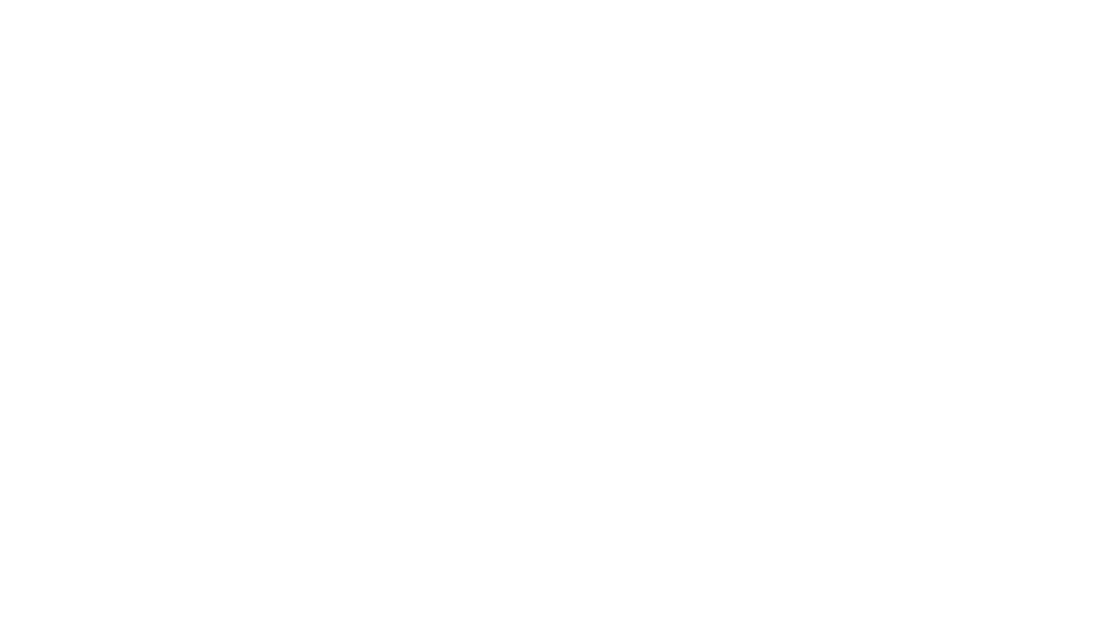

2.9593088203508258e-05
2.9593088203508258e-05
2.9398082775109455e-05
2.9398082775109455e-05
2.8365736013979476e-05
2.8365736013979476e-05
1.4149543047091117e-05
1.4149543047091117e-05


In [43]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, ax, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    ax.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(14, 8), dpi=80)
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1) 


collection_name = 'qband_p63_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'lightblue')
xs, ys = plot_collection(collection_name, ax2, '^', 'lightblue')

collection_name = 'qband_p64_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'darkblue')
xs, ys = plot_collection(collection_name, ax2, '^', 'darkblue')

collection_name = 'qband_p65_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'c')
xs, ys = plot_collection(collection_name, ax2, '^', 'c')

collection_name = 'qband_p65_flip1_mix20k_d200k_loop100_fp'
xs, ys = plot_collection(collection_name, ax1, '^', 'c')
xs, ys = plot_collection(collection_name, ax2, '^', 'c')

ax1.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
ax1.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

ax2.set_ylim(1e-6, 2.5e-6)

ax1.legend(loc='lower right')
plt.xlabel('Field (T)')
plt.ylabel('Normalized Intensity')
plt.show()

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


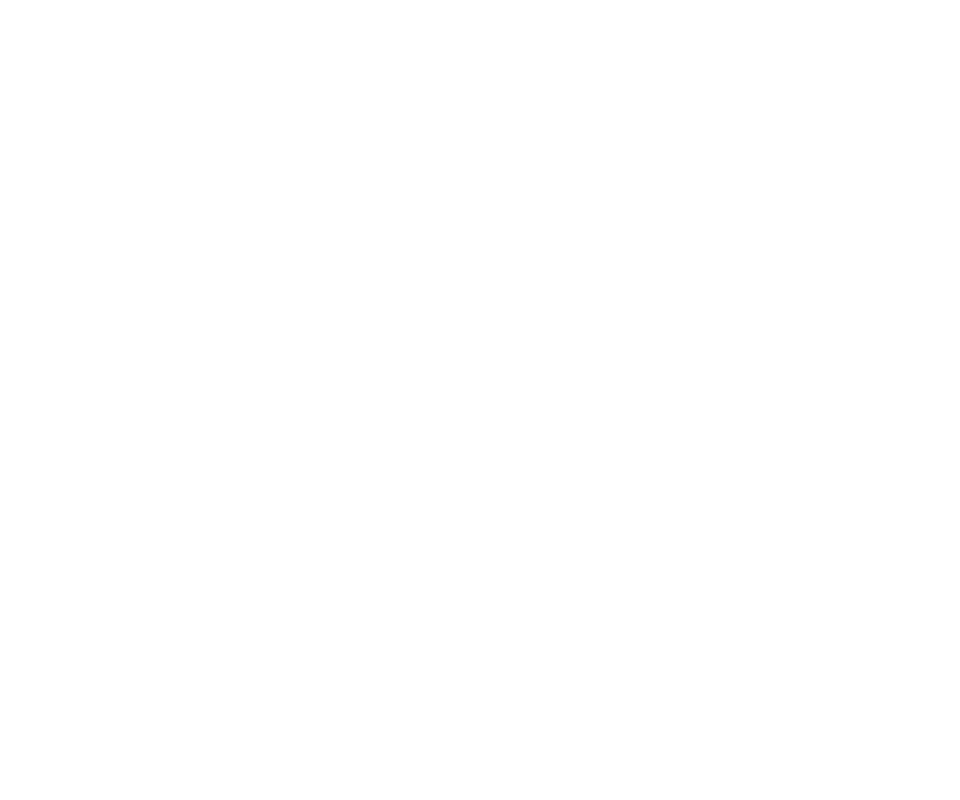

5.1053853429201265e-05
2.426567828412595e-05


In [33]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, ax, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    ax.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(12, 10), dpi=80)
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1)
# ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1) 

# idx=53
# idx=67
idx=68

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop100_fp'
xs_novel, ys_novel = plot_collection(collection_name, ax1, 'o', 'r')
# xs_novel, ys_novel = plot_collection(collection_name, ax2, '^', 'darkblue')

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop100_fp_se'
xs_se, ys_se = plot_collection(collection_name, ax1, 's', 'k')
# xs_se, ys_se = plot_collection(collection_name, ax2, '^', 'c')

ys_diff = np.array(ys_novel) - np.array(ys_se)
ax1.plot(xs_se, ys_diff, marker='^', linestyle='dashed', color='blue', markerfacecolor='none', label='difference')

ax1.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
ax1.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

# ax2.set_ylim(1e-6, 2.5e-6)

ax1.legend(loc='lower right')
plt.xlabel('Field (T)')
ax1.set_ylabel('Intensity')
plt.show()

<IPython.core.display.Javascript object>


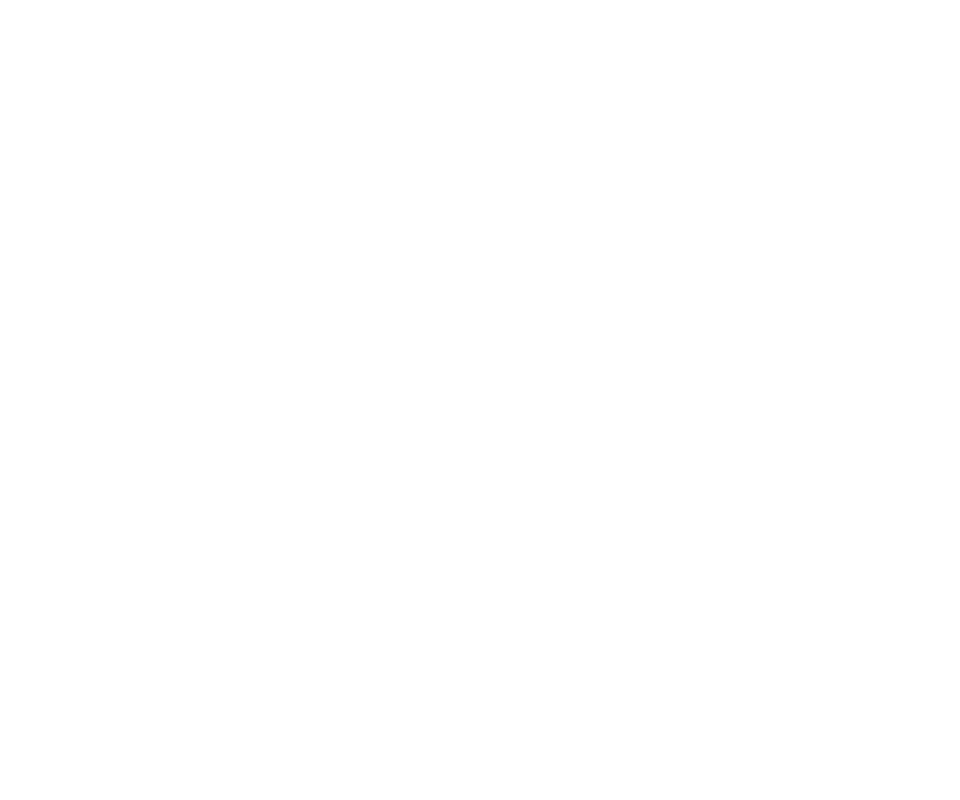

4.2569533042780805e-05
2.426505402860123e-05


In [34]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

def plot_collection(collection_name, ax, marker='o', color='red'):
    xs, ys = get_xy_from_collection(collection_name, eofe_results_root)
#     ys_max = ys[np.argmax(ys)]
    ys_max = 1.0
    ax.plot(np.array(xs), np.array(ys)/ys_max, 
             linestyle='solid', marker=marker, color=color, markerfacecolor='none', 
             label=get_label(collection_name, eofe_results_root))
    print(ys[np.argmax(ys)])
    return xs, ys
    

fig = plt.figure(figsize=(12, 10), dpi=80)
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1)
# ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1) 

# idx=53
# idx=67
idx=68

collection_name = f'qband_p{idx}_flip0p7_mix20k_d200k_loop100_fp_inc0p1'
xs_novel, ys_novel = plot_collection(collection_name, ax1, 'o', 'r')
# xs_novel, ys_novel = plot_collection(collection_name, ax2, '^', 'darkblue')

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop100_fp_se_inc0p1'
xs_se, ys_se = plot_collection(collection_name, ax1, 's', 'k')
# xs_se, ys_se = plot_collection(collection_name, ax2, '^', 'c')

ys_diff = np.array(ys_novel) - np.array(ys_se)
ax1.plot(xs_se, ys_diff, marker='^', linestyle='dashed', color='blue', markerfacecolor='none', label='difference')

ax1.vlines(1.1957, np.min(ys), np.max(ys), linestyle='dashed')
ax1.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

# ax2.set_ylim(1e-6, 2.5e-6)

ax1.legend(loc='lower right')
plt.xlabel('Field (T)')
ax1.set_ylabel('Intensity')
plt.show()

<IPython.core.display.Javascript object>


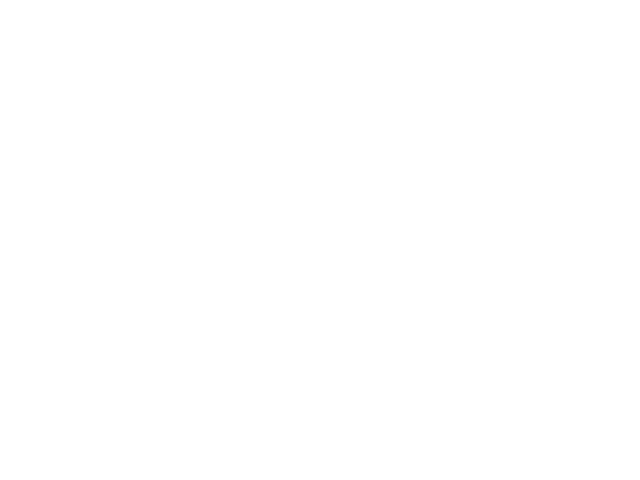

In [35]:
idx=70
fig = plt.figure()
collection_name = f'qband_p{idx}_flip0p9_mix20k_d200k_loop100_fp_inc0p1'
xs_novel, ys_novel = get_xy_from_collection(collection_name, eofe_results_root)
collection_name = f'qband_p{idx}_flip0p8_mix20k_d200k_loop100_fp_inc0p1'
xs_novel2, ys_novel2 = get_xy_from_collection(collection_name, eofe_results_root)
collection_name = f'qband_p{idx}_flip0p8_mix20k_d200k_loop100_fp_se_inc0p1'
xs_se, ys_se = get_xy_from_collection(collection_name, eofe_results_root)
ys_diff1 = np.array(ys_novel) - np.array(ys_se)
ys_diff2 = np.array(ys_novel2) - np.array(ys_se)


plt.plot(xs_novel, ys_diff1, 'b-')
plt.plot(xs_novel2, ys_diff2, 'r-')
plt.show()

<IPython.core.display.Javascript object>


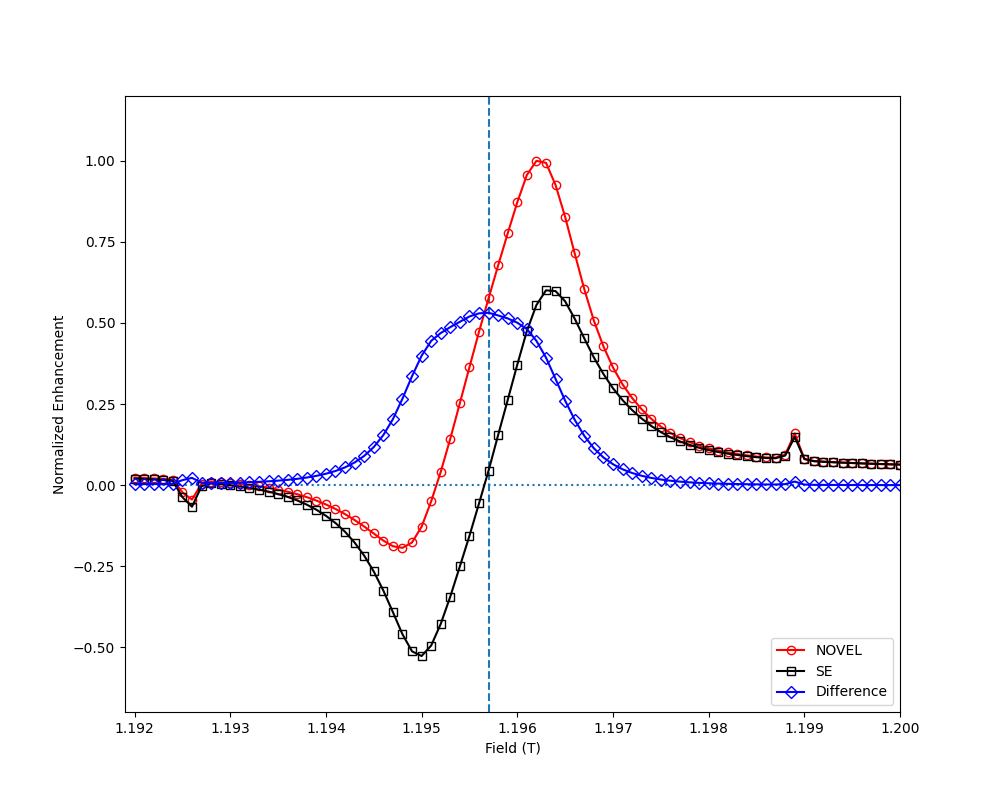

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [86]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

# idx=53
# idx=67
# idx=69
# idx=70
# idx=71
# idx=72
# idx=73
idx=74
# idx=75
loop=200

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop{loop}_fp_ref_inc0p1'
xs_ref, ys_ref = get_xy_from_collection(collection_name, eofe_results_root)

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop{loop}_fp_inc0p1'
xs_novel, ys_novel = get_xy_from_collection(collection_name, eofe_results_root)

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop{loop}_fp_se_inc0p1'
xs_se, ys_se = get_xy_from_collection(collection_name, eofe_results_root)

ys1 = np.array(ys_novel)/np.array(ys_ref)
ys2 = np.array(ys_se)/np.array(ys_ref)

factor = np.max(ys1)

fig = plt.figure(figsize=(10, 8), dpi=100)
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1)

ax1.plot(xs_ref, ys1/factor, marker='o', linestyle='solid', color='r', markerfacecolor='none', label='NOVEL')
ax1.plot(xs_ref, ys2/factor, marker='s', linestyle='solid', color='k', markerfacecolor='none', label='SE')

ys_diff = np.array(ys1) - np.array(ys2)
ax1.plot(xs_se, ys_diff/factor, marker='D', linestyle='solid', color='blue', markerfacecolor='none', label='Difference')

ax1.vlines(1.1957, -0.7, 1.2, linestyle='dashed')
ax1.hlines(0, np.min(xs), np.max(xs), linestyle='dotted')

# ax2.set_ylim(1e-6, 2.5e-6)

ax1.legend(loc='lower right')
plt.xlabel('Field (T)')
ax1.set_ylabel('Normalized Enhancement')
plt.ylim(-0.7, 1.2)
plt.xlim(1.1919, 1.20)
plt.savefig('cody_figure3_fp_simulation_v3.ps')
plt.show()

In [37]:
h = 6.626070040e-34
gH = 42.57747892e6
beta_e = -9.274009994e-24/h
g = np.mean([2.00319, 2.00319, 2.00258])

In [38]:
d_freq = 102e6
d_f = d_freq/(g * beta_e)
d_f

-0.003638401114925771

In [39]:
1.1957 + d_f

1.1920615988850742

In [ ]:
os.getcwd()

<IPython.core.display.Javascript object>


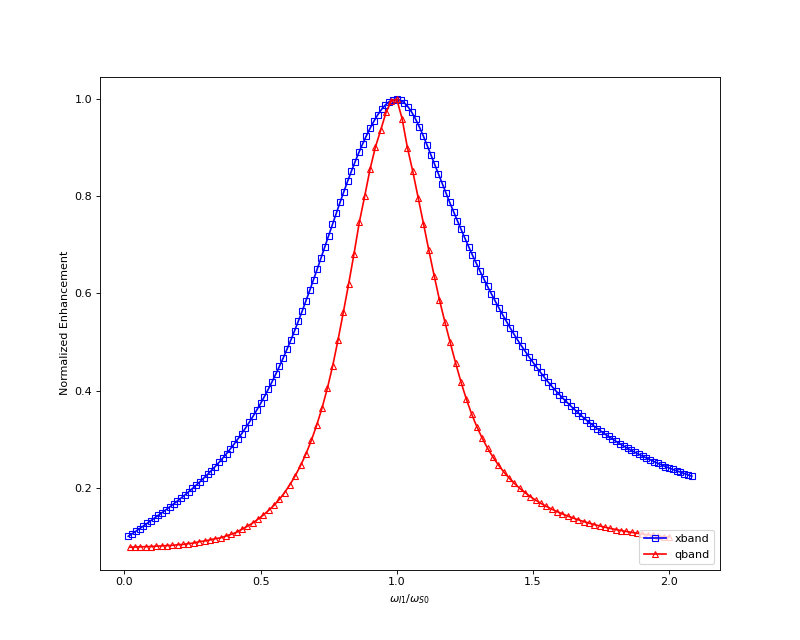

In [76]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_gB1(res_dir, param_dir)
    return xs, ys

# idx=53
# idx=67
# idx=69
# idx=70
# idx=71
# idx=72
# idx=73
idx=74
# idx=75
loop=200



# collection_name = f'xband_p83_flip16_mix400_d100k_loop{loop}_scan_gB1_inc1'
# xs_x, ys_x = get_xy_from_collection(collection_name, eofe_results_root)
collection_name = f'xband_p83_flip16_mix500_d100k_loop{loop}_scan_gB1_inc1'
xs_x2, ys_x2 = get_xy_from_collection(collection_name, eofe_results_root)
collection_name = f'xband_p83_flip16_mix500_d100k_loop{loop}_scan_gB1_ref_inc1'
_, ys_x2_ref = get_xy_from_collection(collection_name, eofe_results_root)

# ys_x_ratio = np.array(ys_x2)/np.array(ys_x2_ref)
# collection_name = f'xband_p83_flip16_mix800_d100k_loop{loop}_scan_gB1_inc1'
# xs_x3, ys_x3 = get_xy_from_collection(collection_name, eofe_results_root)

collection_name = f'qband_p74_flip1_mix20k_d200k_loop{loop}_scan_gB1_inc0p1'
# collection_name = f'qband_p83_flip1_mix500_d100k_loop{loop}_scan_gB1_inc1'
xs_q, ys_q = get_xy_from_collection(collection_name, eofe_results_root)

# collection_name = f'qband_p83_flip1_mix500_d100k_loop{loop}_scan_gB1_ref_inc1'
# _, ys_q_ref = get_xy_from_collection(collection_name, eofe_results_root)
# ys_q_ratio = np.array(ys_q)/np.array(ys_q_ref)


factor = np.max(ys)

fig = plt.figure(figsize=(10, 8), dpi=80)
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1)

# ax1.plot(np.array(xs_x)/xs_x[np.argmax(ys_x)], np.array(ys_x)/ys_x[np.argmax(ys_x)], 
#          marker='o', linestyle='solid', color='lightblue', markerfacecolor='none', label='xband')
ax1.plot(np.array(xs_x2)/xs_x2[np.argmax(ys_x2)], ys_x2/np.max(ys_x2), 
         marker='s', linestyle='solid', color='blue', markerfacecolor='none', label='xband')
# ax1.plot(np.array(xs_x3)/xs_x3[np.argmax(ys_x3)], np.array(ys_x3)/ys_x3[np.argmax(ys_x3)], 
#          marker='o', linestyle='solid', color='blue', markerfacecolor='none', label='xband')

ax1.plot(np.array(xs_q)/xs_q[np.argmax(ys_q)], ys_q/np.max(ys_q), marker='^', linestyle='solid', color='r', markerfacecolor='none', label='qband')

ax1.legend(loc='lower right')
ax1.set_xlabel('$\omega_{I1}/\omega_{S0}$')
ax1.set_ylabel('Normalized Enhancement')
# plt.savefig('cody_figure3_gB1_simulation_v5.ps')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(ys)
plt.show()

<IPython.core.display.Javascript object>


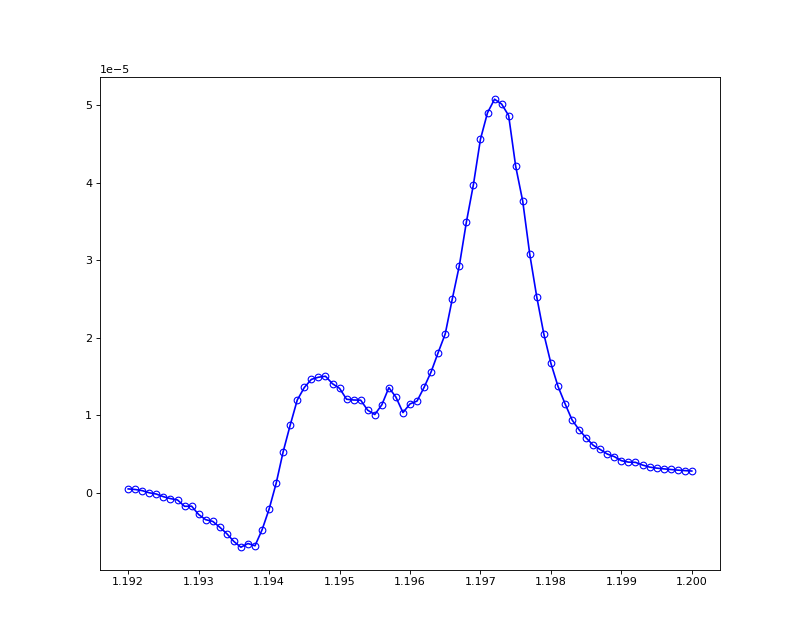

In [85]:
eofe_results_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_outputs/NOVEL/tasks'
eofe_params_root = '/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs/NOVEL'

def get_xy_from_collection(collection_name, eofe_res_dir):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results_fp(res_dir, param_dir)
    return xs, ys

# idx=53
# idx=67
# idx=69
# idx=70
# idx=71
# idx=72
# idx=73
idx=74
# idx=75
loop=200

factor = np.max(ys)

fig = plt.figure(figsize=(10, 8), dpi=80)
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1)

collection_name = f'qband_p74_flip1_mix2k_d200k_loop200_fp_ise_inc1'
xs_x, ys_x = get_xy_from_collection(collection_name, eofe_results_root)
ax1.plot(np.array(xs_x), np.array(ys_x), 
         marker='o', linestyle='solid', color='blue', markerfacecolor='none', label='xband')

plt.show()